In [1]:
import cv2
import numpy as np
import torch


import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def process_image(path, is_gray=False):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img = img / 255.0
    img = np.reshape(img, (1, 420, 540))  
    
    
    img_tensor = torch.from_numpy(img).float()
    
    return img_tensor

In [2]:
import os
train_img = sorted(os.listdir('D:/PRE2023/train'))
train_cleaned_img = sorted(os.listdir('D:/PRE2023/train_cleaned'))
test_img = sorted(os.listdir('D:/PRE2023/test'))

In [3]:
# preprocess images
train = []
train_cleaned = []
test = []


for f in train_img:
    train_path = os.path.join('D:/PRE2023/train', f)
    train_cleaned_path = os.path.join('D:/PRE2023/train_cleaned', f)
    
    
    if cv2.imread(train_path).shape[-1] == 1:
        train.append(process_image(train_path, is_gray=True))
        train_cleaned.append(process_image(train_cleaned_path, is_gray=True))
    else:
        train.append(process_image(train_path))
        train_cleaned.append(process_image(train_cleaned_path))

for f in test_img:
    test_path = os.path.join('D:/PRE2023/test', f)
    
    if cv2.imread(test_path).shape[-1] == 1:
        test.append(process_image(test_path, is_gray=True))
    else:
        test.append(process_image(test_path))

In [5]:
from sklearn.model_selection import train_test_split



X_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train])
Y_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train_cleaned])
X_test = torch.stack([torch.tensor(sample).clone().detach() for sample in test])


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_14092\2905057465.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train])
C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_14092\2905057465.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train_cleaned])
C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_14092\2905057465.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.

In [8]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        # decoder
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        
        # decoder
        x = self.upsample1(torch.relu(self.conv3(x)))
        x = self.upsample2(torch.relu(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        
        return x


autoencoder1 = Autoencoder()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable



train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)


autoencoder1 = Autoencoder().to('cuda')


criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder1.parameters())  


best_val_loss = float('inf')
patience = 30
counter = 0


num_epochs = 50
for epoch in range(num_epochs):
    autoencoder1.train()
    train_loss = 0.0
    
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')  
        optimizer.zero_grad()
        outputs = autoencoder1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    
    autoencoder1.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')  
            outputs = autoencoder1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Epoch [1/50], Loss: 0.4509, Val Loss: 0.3894
Epoch [2/50], Loss: 0.3513, Val Loss: 0.3651
Epoch [3/50], Loss: 0.3386, Val Loss: 0.3494
Epoch [4/50], Loss: 0.3145, Val Loss: 0.3023
Epoch [5/50], Loss: 0.2637, Val Loss: 0.2627
Epoch [6/50], Loss: 0.2378, Val Loss: 0.2443
Epoch [7/50], Loss: 0.2199, Val Loss: 0.2224
Epoch [8/50], Loss: 0.2079, Val Loss: 0.2207
Epoch [9/50], Loss: 0.1985, Val Loss: 0.2022
Epoch [10/50], Loss: 0.1868, Val Loss: 0.1909
Epoch [11/50], Loss: 0.1773, Val Loss: 0.1869
Epoch [12/50], Loss: 0.1764, Val Loss: 0.1797
Epoch [13/50], Loss: 0.1702, Val Loss: 0.1728
Epoch [14/50], Loss: 0.1655, Val Loss: 0.1698
Epoch [15/50], Loss: 0.1617, Val Loss: 0.1673
Epoch [16/50], Loss: 0.1585, Val Loss: 0.1671
Epoch [17/50], Loss: 0.1543, Val Loss: 0.1604
Epoch [18/50], Loss: 0.1522, Val Loss: 0.1580
Epoch [19/50], Loss: 0.1507, Val Loss: 0.1561
Epoch [20/50], Loss: 0.1489, Val Loss: 0.1543
Epoch [21/50], Loss: 0.1465, Val Loss: 0.1520
Epoch [22/50], Loss: 0.1452, Val Loss: 0.15

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [11]:
class Raylu(nn.Module): 
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) 

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=temp2=torch.min(torch.zeros_like(input),input*torch.exp(-input**2/self.sigma**2/2))
        x=temp1+temp2
        return x

In [12]:
class AutoencoderP(nn.Module):
    def __init__(self):
        super(AutoencoderP, self).__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        # decoder
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.Raylu1 = Raylu()
        self.Raylu2 = Raylu()
        self.Raylu3 = Raylu()
        self.Raylu4 = Raylu()
    def forward(self, x):
        # encoder
        x = self.pool1(self.Raylu1(self.conv1(x)))
        x = self.pool2(self.Raylu2(self.conv2(x)))
        
        # decoder
        x = self.upsample1(self.Raylu3(self.conv3(x)))
        x = self.upsample2(self.Raylu4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        
        return x
autoencoder = AutoencoderP().to('cuda')

In [13]:


train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)


criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters())  


num_epochs = 50
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')  
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

   
    autoencoder.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')  
            outputs = autoencoder(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Epoch [1/50], Loss: 0.3877, Val Loss: 0.3682
Epoch [2/50], Loss: 0.3109, Val Loss: 0.2780
Epoch [3/50], Loss: 0.2528, Val Loss: 0.2632
Epoch [4/50], Loss: 0.2361, Val Loss: 0.2408
Epoch [5/50], Loss: 0.2199, Val Loss: 0.2244
Epoch [6/50], Loss: 0.2052, Val Loss: 0.2095
Epoch [7/50], Loss: 0.1918, Val Loss: 0.1965
Epoch [8/50], Loss: 0.1823, Val Loss: 0.1865
Epoch [9/50], Loss: 0.1735, Val Loss: 0.1790
Epoch [10/50], Loss: 0.1679, Val Loss: 0.1711
Epoch [11/50], Loss: 0.1612, Val Loss: 0.1657
Epoch [12/50], Loss: 0.1564, Val Loss: 0.1607
Epoch [13/50], Loss: 0.1529, Val Loss: 0.1566
Epoch [14/50], Loss: 0.1499, Val Loss: 0.1532
Epoch [15/50], Loss: 0.1479, Val Loss: 0.1560
Epoch [16/50], Loss: 0.1459, Val Loss: 0.1487
Epoch [17/50], Loss: 0.1423, Val Loss: 0.1468
Epoch [18/50], Loss: 0.1402, Val Loss: 0.1447
Epoch [19/50], Loss: 0.1389, Val Loss: 0.1429
Epoch [20/50], Loss: 0.1371, Val Loss: 0.1410
Epoch [21/50], Loss: 0.1345, Val Loss: 0.1395
Epoch [22/50], Loss: 0.1335, Val Loss: 0.13

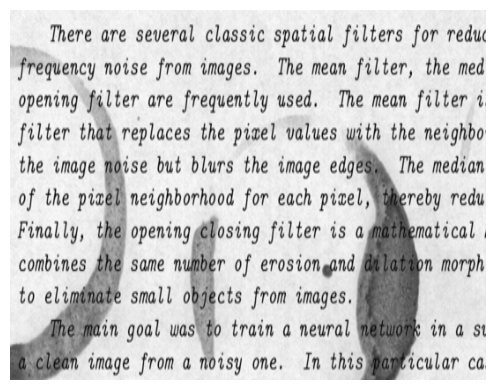

In [31]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF  

selected_images = []

image, label = val_dataset[8]

    
image = TF.to_pil_image(image)  

    
selected_images.append(image)


plt.figure(figsize=(6, 4))

plt.imshow(selected_images[0], cmap='gray')  
   
plt.axis('off')

plt.tight_layout()
plt.savefig('textAEoriginalPic3new.jpg', dpi=150)  
plt.show()

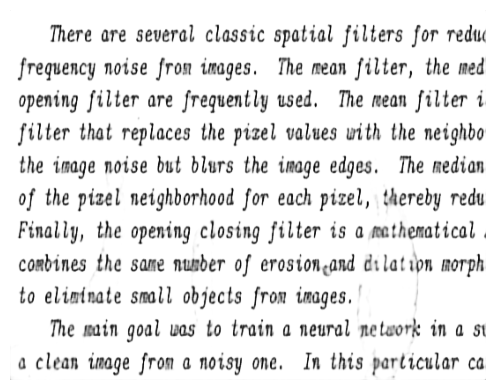

In [32]:
from torchvision import datasets,transforms

reconstructed_images1 = []


autoencoder.eval()



transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

with torch.no_grad():
    for image in selected_images:
       
        image_tensor = transform2(image).unsqueeze(dim=0) 
        image_tensor = image_tensor.to('cuda')

        
        reconstructed_image = autoencoder(image_tensor)
        reconstructed_pil_image = TF.to_pil_image(reconstructed_image.squeeze().cpu())

        
        reconstructed_images1.append(reconstructed_pil_image)

plt.figure(figsize=(6, 4))

plt.imshow(reconstructed_images1[0], cmap='gray') 

plt.axis('off')

plt.tight_layout()
#plt.savefig('textAEOptunaPaylu3.jpg', dpi=150)  
plt.show()

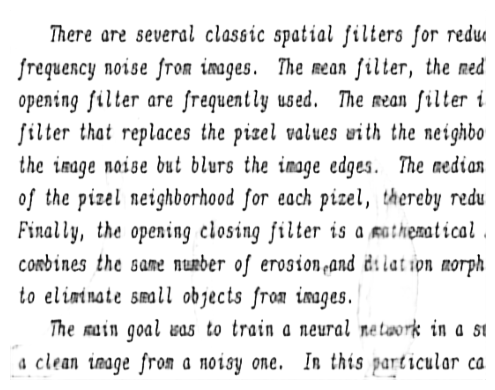

In [33]:
from torchvision import datasets,transforms

reconstructed_images1 = []


autoencoder1.eval()



transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

with torch.no_grad():
    for image in selected_images:
       
        image_tensor = transform2(image).unsqueeze(dim=0) 
        image_tensor = image_tensor.to('cuda')

        
        reconstructed_image = autoencoder1(image_tensor)
        reconstructed_pil_image = TF.to_pil_image(reconstructed_image.squeeze().cpu())

        
        reconstructed_images1.append(reconstructed_pil_image)

plt.figure(figsize=(6, 4))

plt.imshow(reconstructed_images1[0], cmap='gray') 

plt.axis('off')

plt.tight_layout()
#plt.savefig('textAEOptunaPaylu3.jpg', dpi=150)  
plt.show()